In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt

In [185]:
df_1999 = pd.read_csv("../data/ResaleFlatPricesBasedonApprovalDate19901999.csv")
df_2012 = pd.read_csv("../data/ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv")
df_2014 = pd.read_csv("../data/ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv")
df_2016 = pd.read_csv("../data/ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv")
df_2017 = pd.read_csv("../data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

`clean_dataset` removes duplicates and returns the number of missing values per column

`split_categorical_numerical` ...

Side note: added .copy() to df_cleaned = df.drop_duplicates() to get rid of slicing warning popping up non stop later on


In [186]:
# Pipelines

# checking for Na and duplicates
def clean_dataset(df, dataset_name):
    print(f"Cleaning dataset: {dataset_name}")
    
    # Check for duplicates
    duplicates_count = df.duplicated().sum()
    print(f"{dataset_name}: Number of duplicates: {duplicates_count}")
    
    # Drop duplicates
    df_cleaned = df.drop_duplicates().copy()          
    
    # Check for missing values
    missing_values = df_cleaned.isna().sum()
    print(f"{dataset_name}: Missing values per column:")
    print(missing_values)
    
    return df_cleaned

# splitting categorical and numerical values:
def split_categorical_numerical(df):
    categorical_columns = df.select_dtypes(include=['object'])
    numerical_columns = df.select_dtypes(include=['number'])
    return categorical_columns, numerical_columns

In [187]:
# Clean and split each dataset, and save them with variable names

# 1. Clean and split df_1999
df_1999_cleaned = clean_dataset(df_1999, "1999")
df_1999_col, df_1999_num = split_categorical_numerical(df_1999_cleaned)

# 2. Clean and split df_2012
df_2012_cleaned = clean_dataset(df_2012, "2012")
df_2012_col, df_2012_num = split_categorical_numerical(df_2012_cleaned)

# 3. Clean and split df_2014
df_2014_cleaned = clean_dataset(df_2014, "2014")
df_2014_col, df_2014_num = split_categorical_numerical(df_2014_cleaned)

# 4. Clean and split df_2016
df_2016_cleaned = clean_dataset(df_2016, "2016")
df_2016_col, df_2016_num = split_categorical_numerical(df_2016_cleaned)

# 5. Clean and split df_2017
df_2017_cleaned = clean_dataset(df_2017, "2017")
df_2017_col, df_2017_num = split_categorical_numerical(df_2017_cleaned)


Cleaning dataset: 1999
1999: Number of duplicates: 826
1999: Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64
Cleaning dataset: 2012
2012: Number of duplicates: 513
2012: Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64
Cleaning dataset: 2014
2014: Number of duplicates: 248
2014: Missing values per column:
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_comm

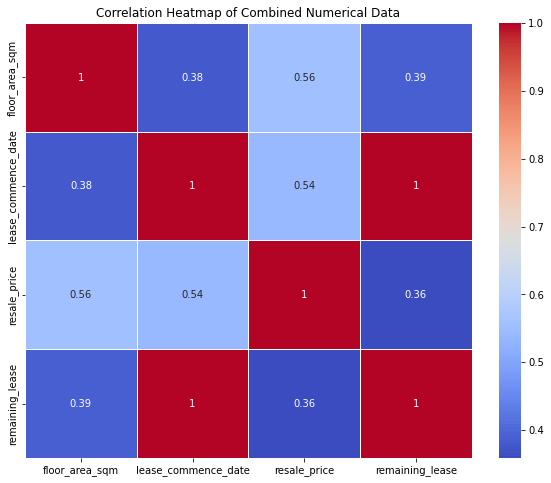

In [188]:
# creating a heat map of the numerical values
numerical_combined = pd.concat([df_1999_num, df_2012_num, df_2014_num, df_2016_num, df_2017_num])
correlation_matrix = numerical_combined.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Combined Numerical Data')
plt.show()

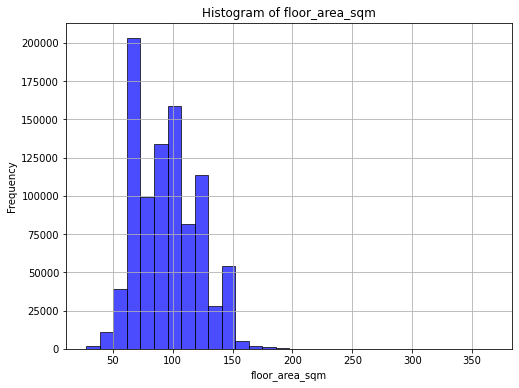

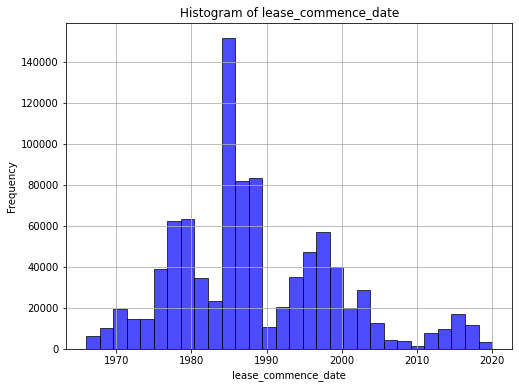

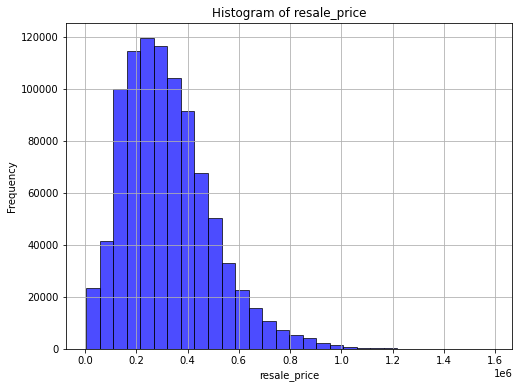

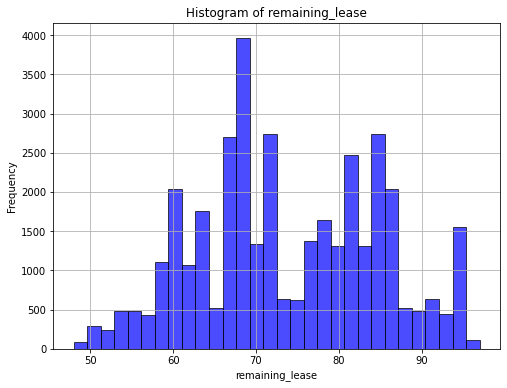

In [189]:
numerical_columns = numerical_combined.columns
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(numerical_combined[column], bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

List of functions for data preparation, data normalisation and data information.


#### **Data Normalisation/Conversion???**

`clean_flat_model` convert all `str` to uppercase and strip whitespaces left and right

`convert_remaining_lease` convert the types(`timedelta`, `int` and `str`) into `float` type

`convert_month_to_datetime` convert `month` column from `str` to `datetime`


#### **Data Preparation**

`split_storey_range` add in the columns of `lower_storey` and `upper_storey` derived from  `storey_range`

`split_month_column` add in the columns of `year` and `month_number` derived from `month`

`add_max_storey` add in the column `max_storey` for each building (at the very least the highest storey recorded)



#### **Data Information**

`filter_building` takes in the input of (df,'town', 'block', 'street_name'), and return all the transaction related to that buildling

`get_column_data_types` displays the total number of each type for each column

**take note that the value Nan is still considered a float type in python, but this function do not consider Nan as float but its seperate group** 

In [199]:
def clean_flat_model(df):
    df['flat_model'] = df['flat_model'].str.strip().str.upper()
    return df 


def split_storey_range(df):
    """
    Splits the 'storey_range' column into 'lower_storey' and 'upper_storey'.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the 'storey_range' column.
    
    Returns:
    pd.DataFrame: Modified DataFrame with 'lower_storey' and 'upper_storey' columns added.
    """
    # Splitting the 'storey_range' column into 'lower_storey' and 'upper_storey'
    df[['lower_storey', 'upper_storey']] = df['storey_range'].str.split(' TO ', expand=True)

    # Convert lower_storey and upper_storey to numeric types
    df['lower_storey'] = pd.to_numeric(df['lower_storey'], errors='coerce')
    df['upper_storey'] = pd.to_numeric(df['upper_storey'], errors='coerce')

    return df


def split_month_column(df):
    """
    Splits the 'month' column into 'year' and 'month_number'.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the 'month' column.
    
    Returns:
    pd.DataFrame: Modified DataFrame with 'year' and 'month_number' columns added.
    """
    # Splitting the 'month' column into 'year' and 'month_number'
    df['year'] = pd.to_datetime(df['month']).dt.year
    df['month_number'] = pd.to_datetime(df['month']).dt.month

    return df


def add_max_storey(df):
    """
    Adds a column 'max_storey' to the DataFrame based on the maximum upper_storey 
    for each unique combination of town, block, and street_name.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'town', 'block', 'street_name', and 'upper_storey'.

    Returns:
    pd.DataFrame: Modified DataFrame with the new 'max_storey' column.
    """
    
    # Create max_storey column
    df['max_storey'] = df.groupby(['town', 'block', 'street_name'])['upper_storey'].transform('max')
    
    return df


def convert_remaining_lease(df):

    for index, row in df.iterrows():

        # case to ignore Nan, and avoid error
        if pd.isna(row['remaining_lease']):
            continue

        # Convert remaining_lease that are string to float
        elif isinstance(row['remaining_lease'], str):
            remaining_lease_str = row["remaining_lease"].lower()
            years = 0
            months = 0
            
            if 'years' in remaining_lease_str:
                years = int(remaining_lease_str.split('years')[0].strip())
            if 'months' in remaining_lease_str:
                months = int(remaining_lease_str.split('months')[0].split()[-1].strip())
            df.loc[index, 'remaining_lease'] = years + months / 12
        
        # convert remaining_lease that are timedelta to float, needed for code below(filling of remaining_lease)
        elif isinstance(row['remaining_lease'], pd.Timedelta):
            df.loc[index, 'remaining_lease'] = float(row['remaining_lease'].days / 365)

        # convert remaining_lease that are int to float
        elif isinstance(row['remaining_lease'], int):
            df.loc[index, 'remaining_lease'] = float(row['remaining_lease'])

    return df


def filter_building(df, town, block, street_name):
    """
    Filters the DataFrame for listings of a specific building.

    Parameters:
    df (pd.DataFrame): The DataFrame containing property listings.
    town (str): The town of the building.
    block (int): The block number of the building.
    street_name (str): The street name of the building.

    Returns:
    pd.DataFrame: Filtered DataFrame containing listings for the specified building.
    """
    filtered_df = df[(df['town'] == town) & 
                     (df['block'] == block) & 
                     (df['street_name'] == street_name)]
    
    num_rows = len(filtered_df)
    print(f"Total number of transactions for the building: {num_rows}")
    #print(filtered_df)
    return filtered_df


def get_column_data_types(df):

    # do take note that Nan is considered as a float type
    if isinstance(df, pd.Series):
        data_types = df.apply(lambda x: 'NaN' if pd.isna(x) else type(x))
        data_types = data_types.value_counts()
    else:
        data_types = df.applymap(lambda x: 'NaN' if pd.isna(x) else type(x))
        data_types = data_types.apply(lambda x: x.value_counts())
    print(data_types)


def convert_month_to_datetime(df, column_name='month'):
    df[column_name] = pd.to_datetime(df[column_name], format='%Y-%m', errors='coerce')
    return df

#### Making of full data

In [191]:
dataframes = [
    df_2017_cleaned,
    df_2016_cleaned,
    df_2014_cleaned,
    df_2012_cleaned,
    df_1999_cleaned
]

full_cleaned = pd.concat(dataframes, ignore_index=True)

In [192]:
full_cleaned = split_month_column(full_cleaned)
full_cleaned = split_storey_range(full_cleaned)
full_cleaned = add_max_storey(full_cleaned)
full_cleaned = convert_month_to_datetime(full_cleaned)
full_cleaned = clean_flat_model(full_cleaned)

Number of `remaining_lease` that have data is 226161 where 37129 is int and 189032 is str, and there is a total of 707463 missing data


In [193]:
# get_column_data_types(full_cleaned["remaining_lease"])

# full_cleaned = convert_remaining_lease(full_cleaned)

# print("")
# print("After convert remaining_lease: ")
# get_column_data_types(full_cleaned["remaining_lease"])

###### Footnote: In the code later on for filling `remaining_lease` missing values, the code can work with either pre-conversion and post-conversion `remaining_lease`, so the code above to convert the type in `remaining_lease` might be redundant, this is because after filling `remaining_lease` missing values we will still need to run `convert_remaining_lease` one more time

#### Sorting by date of transaction

In [195]:
#Sort them by descending order of month
full_cleaned = full_cleaned.sort_values(by='month', ascending=False)

In [196]:
full_cleaned

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_number,lower_storey,upper_storey,max_storey
188357,2024-09-01,BEDOK,3 ROOM,121,BEDOK RESERVOIR RD,04 TO 06,67.0,NEW GENERATION,1985,59 years 11 months,445000.0,2024,9,4,6,12
188503,2024-09-01,CHOA CHU KANG,5 ROOM,353,CHOA CHU KANG CTRL,10 TO 12,123.0,IMPROVED,1993,67 years 10 months,675000.0,2024,9,10,12,15
188568,2024-09-01,HOUGANG,5 ROOM,915,HOUGANG ST 91,13 TO 15,121.0,IMPROVED,1998,72 years 06 months,700000.0,2024,9,13,15,18
188567,2024-09-01,HOUGANG,5 ROOM,970,HOUGANG ST 91,10 TO 12,120.0,IMPROVED,1999,74 years 04 months,715000.0,2024,9,10,12,15
188566,2024-09-01,HOUGANG,5 ROOM,927,HOUGANG ST 91,10 TO 12,120.0,IMPROVED,1998,73 years 04 months,755000.0,2024,9,10,12,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648252,1990-01-01,KALLANG/WHAMPOA,3 ROOM,49,DORSET RD,04 TO 06,68.0,NEW GENERATION,1979,NaN,52000.0,1990,1,4,6,15
648253,1990-01-01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,NaN,58000.0,1990,1,1,3,9
648254,1990-01-01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,NaN,77000.0,1990,1,4,6,12
648255,1990-01-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,NaN,66500.0,1990,1,4,6,12


## Code for finding `remaining_lease` for pre-Jan 2015

`remaining_lease` from Jan 2015 to Dec 2016 are in `int`

While `remaining_lease` from Jan 2017 onwards are in `str` and are in the format of "## years ## months" or " ## years"

Meanwhile, `remaining_lease` in pre-Jan 2015 are not available/Nan

Thus, this function aims to figure out the `remaining_lease` in the data of pre-Jan 2015 by finding out what is the lease end date using data from Jan 2015 onwards

Data is sorted from latest to earliest date of transaction as the latest transaction `remaining_lease` can dervie number of years and months left while 2015 to 2016 data only derive number of years left, so sorting in descending order would ensure the dictionary will be filled with the most updated data

### Additional information:

For buildings that `remaining_lease` are still Nan after running this code, it means those building do not have transactions post-Jan 2015

Likely those buildings were scheduled for en-bloc and are either already demolished or preparing to be demolished, hence the lack of transactions post-Jan 2015

For more information, google search "completed SERS projects"

###### Footnote: too lazy to reconfigure this into a function, and clean up legacy code after some optimisation  

In [197]:
# unique_buildings is a list of unique tuples(town, block, street_name)
unique_buildings = full_cleaned[['town', 'block', 'street_name']].drop_duplicates().values.tolist()

# Create a dictionary with keys as unique buildings and values initialized to None
building_dict = {(town, block, street_name): None for town, block, street_name in unique_buildings}


print("Succesfully created building dictionary: ", len(building_dict))

#full_cleaned.sort_values(by='month', ascending=False)  # ignore if sorted by descending order already

# Filling the values of building_dict with the lease end date(+-1 month) by deriving lease_end_date = month + remaining_lease
# Iterate through each row in full_cleaned
for index, row in full_cleaned.iterrows():

    key = (row['town'], row['block'], row['street_name'])

    # Skip rows with NaN remaining_lease
    if pd.isna(row['remaining_lease']):
        continue
    
    # Skip rows if building already has a value in the dictionary
    if building_dict[key] is not None:
        continue
    
    # Convert remaining_lease if there are in string to datetime forma
    if isinstance(row['remaining_lease'], str):
    
        remaining_lease_str = row["remaining_lease"].lower()

        years = 0
        months = 0

        # Calcaulation for remaining_lease if its in string type
        if 'years' in remaining_lease_str:
            years = int(remaining_lease_str.split('years')[0].strip())
        if 'months' in remaining_lease_str:
            months = int(remaining_lease_str.split('months')[0].split()[-1].strip())
        remaining_lease = pd.offsets.DateOffset(years=years, months=months)
        # Calculate lease_end_date
        lease_end_date = row['month'] + remaining_lease

    # Calcaulation for remaining_lease if its in int or float type
    elif isinstance(row['remaining_lease'], (int, float)):
        years = int(row['remaining_lease'])
        months = int((row['remaining_lease'] - years) * 12) + 1
        remaining_lease = pd.offsets.DateOffset(years=years, months=months)
        # Calculate lease_end_date
        lease_end_date = row['month'] + remaining_lease
    
    # Update building_dict with lease_end_date
    building_dict[key] = lease_end_date

print("Successfully filled lease end date for each building")

# Iterate through each row in full_cleaned to fill remaining_lease that are Nan
for index, row in full_cleaned.iterrows():

    key = (row['town'], row['block'], row['street_name'])

    # happens when there is no transaction for that building post-Jan 2015
    if building_dict[key] is None:
        continue

    if pd.isna(row['remaining_lease']):
        # Calculate lease_end_date using building_dict
        remaining_lease = building_dict[key] - row['month']
        
        # Update remaining_lease in full_cleaned
        full_cleaned.loc[index, 'remaining_lease'] = remaining_lease

    # this is to ignore rows where remaining_lease already have original data
    else:
        continue

print("Successfully filled missing remaining lease for each building")

# sort again but this time from earlist to latest date of transaction
full_cleaned = full_cleaned.sort_values(by='month', ascending=True)

Succesfully created building dictionary:  9846
Successfully filled lease end date for each building
Successfully filled missing remaining lease for each building


##### After conversion of remaining_lease number of missing data is cut down from 707463 to 18994

In [200]:
# run convert_remaing_lease again as the newly updated values in "remaining_lease" are in timedelta

get_column_data_types(full_cleaned["remaining_lease"])

convert_remaining_lease(full_cleaned)

get_column_data_types(full_cleaned["remaining_lease"])

<class 'float'>    725598
<class 'str'>      189032
NaN                 18994
Name: remaining_lease, dtype: int64
<class 'float'>    914630
NaN                 18994
Name: remaining_lease, dtype: int64


### Overview of data

In [201]:
full_cleaned

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_number,lower_storey,upper_storey,max_storey
648748,1990-01-01,YISHUN,EXECUTIVE,326,YISHUN RING RD,10 TO 12,146.0,MAISONETTE,1988,97.646575,192000.0,1990,1,10,12,15
647275,1990-01-01,ANG MO KIO,3 ROOM,329,ANG MO KIO AVE 3,07 TO 09,73.0,NEW GENERATION,1978,87.145205,40000.0,1990,1,7,9,15
647274,1990-01-01,ANG MO KIO,3 ROOM,230,ANG MO KIO AVE 3,07 TO 09,82.0,NEW GENERATION,1978,87.145205,60000.0,1990,1,7,9,12
647273,1990-01-01,ANG MO KIO,3 ROOM,223,ANG MO KIO AVE 1,10 TO 12,67.0,NEW GENERATION,1978,87.145205,37000.0,1990,1,10,12,12
647254,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,NaN,9000.0,1990,1,10,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189023,2024-09-01,YISHUN,5 ROOM,318A,YISHUN AVE 9,07 TO 09,112.0,IMPROVED,2015,90.166667,718000.0,2024,9,7,9,15
188990,2024-09-01,YISHUN,3 ROOM,823,YISHUN ST 81,01 TO 03,64.0,SIMPLIFIED,1992,66.833333,433000.0,2024,9,1,3,6
189012,2024-09-01,YISHUN,4 ROOM,717,YISHUN ST 71,01 TO 03,84.0,SIMPLIFIED,1987,62.25,463000.0,2024,9,1,3,12
188970,2024-09-01,WOODLANDS,5 ROOM,686A,WOODLANDS DR 73,13 TO 15,114.0,PREMIUM APARTMENT,2003,77.5,635000.0,2024,9,13,15,15


In [212]:
get_column_data_types(full_cleaned)

                                                       month      town  \
<class 'pandas._libs.tslibs.timestamps.Timestamp'>  933624.0       NaN   
<class 'str'>                                            NaN  933624.0   
<class 'float'>                                          NaN       NaN   
<class 'int'>                                            NaN       NaN   
NaN                                                      NaN       NaN   

                                                    flat_type     block  \
<class 'pandas._libs.tslibs.timestamps.Timestamp'>        NaN       NaN   
<class 'str'>                                        933624.0  933624.0   
<class 'float'>                                           NaN       NaN   
<class 'int'>                                             NaN       NaN   
NaN                                                       NaN       NaN   

                                                    street_name  storey_range  \
<class 'pandas._libs.ts

#### Distribution of the maximum storey

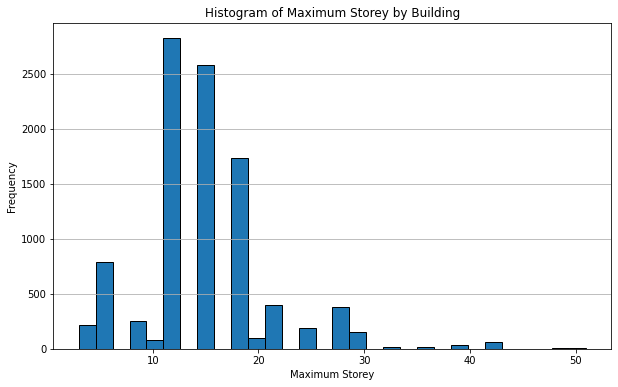

In [202]:
lst_of_max_storey = full_cleaned.groupby(['town', 'block', 'street_name'], as_index=False)['max_storey'].max()

# Plot the histogram of max_storey
plt.figure(figsize=(10, 6))
plt.hist(lst_of_max_storey['max_storey'], bins=30, edgecolor='black')
plt.title('Histogram of Maximum Storey by Building')
plt.xlabel('Maximum Storey')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

#### Number of unique buildings

In [203]:
# Count unique buildings based on town, block, and street_name
unique_buildings_count = full_cleaned.groupby(['town', 'block', 'street_name']).size().count()

# Display the total number of unique buildings
print(f"Total number of unique buildings: {unique_buildings_count}")

Total number of unique buildings: 9846


#### Data exploration using filter_building

In [204]:
# input: (df, 'town', 'block', 'street_name'); case-sensitve 
filter_building(full_cleaned, 'KALLANG/WHAMPOA', '28', 'JLN BAHAGIA')

Total number of transactions for the building: 164


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_number,lower_storey,upper_storey,max_storey
648257,1990-01-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,01 TO 03,56.0,STANDARD,1971,80.054795,26000.0,1990,1,1,3,12
648258,1990-01-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,07 TO 09,56.0,STANDARD,1971,80.054795,23500.0,1990,1,7,9,12
649362,1990-02-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,04 TO 06,56.0,STANDARD,1971,79.969863,26600.0,1990,2,4,6,12
657313,1990-10-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,04 TO 06,56.0,STANDARD,1971,79.306849,24000.0,1990,10,4,6,12
657314,1990-10-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,01 TO 03,56.0,STANDARD,1971,79.306849,20000.0,1990,10,1,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155027,2023-06-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,10 TO 12,56.0,STANDARD,1971,46.583333,290000.0,2023,6,10,12,12
179248,2024-05-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,07 TO 09,56.0,STANDARD,1971,45.75,284000.0,2024,5,7,9,12
184141,2024-07-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,07 TO 09,56.0,STANDARD,1971,45.583333,325000.0,2024,7,7,9,12
184143,2024-07-01,KALLANG/WHAMPOA,3 ROOM,28,JLN BAHAGIA,07 TO 09,56.0,STANDARD,1971,45.583333,295000.0,2024,7,7,9,12


Eg of a building that was scheduled for en-bloc hence last transaction date are in 1999

In [205]:
filter_building(full_cleaned, 'ANG MO KIO', '309', 'ANG MO KIO AVE 1')

Total number of transactions for the building: 223


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,month_number,lower_storey,upper_storey,max_storey
647254,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,NaN,9000.0,1990,1,10,12,12
647255,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,NaN,6000.0,1990,1,4,6,12
647256,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,NaN,8000.0,1990,1,10,12,12
647257,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,NaN,6000.0,1990,1,7,9,12
648750,1990-02-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,01 TO 03,31.0,IMPROVED,1977,NaN,8000.0,1990,2,1,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930828,1999-12-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,NaN,60000.0,1999,12,7,9,12
930838,1999-12-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,NaN,63500.0,1999,12,10,12,12
930829,1999-12-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,NaN,62500.0,1999,12,4,6,12
930820,1999-12-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,NaN,67500.0,1999,12,10,12,12


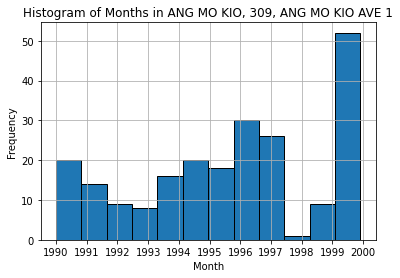

In [210]:

# Filter the DataFrame to select the area 'ANG MO KIO', '309', 'ANG MO KIO AVE 1'
selected_area = full_cleaned.loc[(full_cleaned['town'] == 'ANG MO KIO') &
                                 (full_cleaned['block'] == '309') &
                                 (full_cleaned['street_name'] == 'ANG MO KIO AVE 1')]

# Plot a histogram of the 'month' column in the selected area
selected_area['month'].hist(bins=12, edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Histogram of Months in ANG MO KIO, 309, ANG MO KIO AVE 1')
plt.show()